### Playground and Tutorials for Julia Modeling Toolkit

In [1]:
using ModelingToolkit
using ModelingToolkit: t_nounits as t, D_nounits as D
using OrdinaryDiffEq
using Plots

Simple example of a first-order lag element
$
\begin{equation}
    \dot{x} = \frac{f(t) - x(t)}{\tau}
\end{equation}
$
where $t$ is the independent variable (time), x(t) is the (scalar) unknown variable, f(t) is the external forcing function, and $\tau$ is a paramater. Independent variable $t$ is automatically generated by @mtkmodel. For first example, set the external forcing function to 1 across all time.

Note: equations in MTK use the tilde character (~) as equality sign.

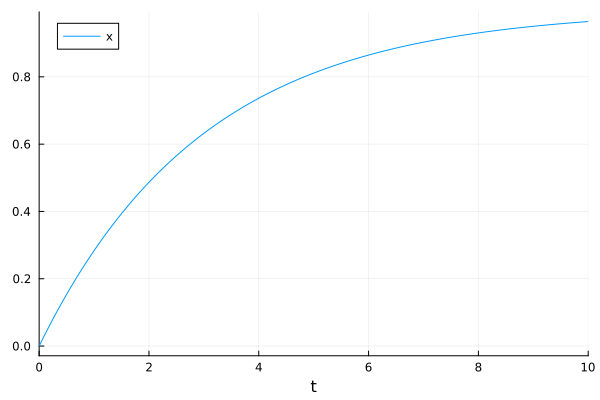

In [20]:
@mtkmodel FOL begin
    @parameters begin
        τ = 3.0 # parameters and their values
    end
    @variables begin
        x(t) = 0.0 # dependent variables and their initial conditions
    end
    @equations begin
        D(x) ~ (1 - x) / τ
    end
end

@mtkbuild fol = FOL()

prob = ODEProblem(fol, [], (0.0, 10.0), [])
plot(solve(prob))

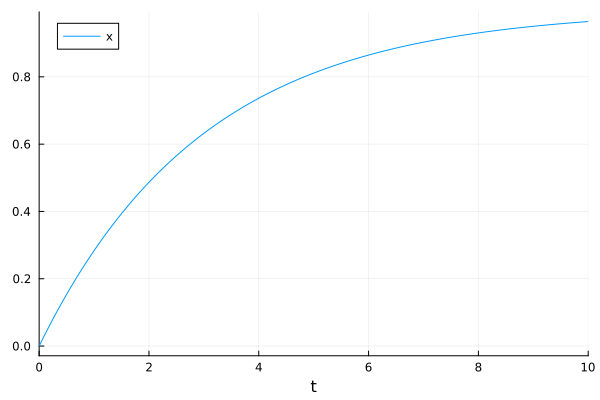

In [21]:
prob = ODEProblem(fol, [], (0.0, 10.0), [])
plot(solve(prob))

### Play with that
$
\begin{equation}
    \dot{x} = \frac{f(t) - x(t)}{\tau}
\end{equation}
$

In [22]:
@mtkmodel FOL begin
    @parameters begin
        τ = 3.0 # parameters and their values
    end
    @variables begin
        x(t) = 0.0 # dependent variables and their initial conditions
        func(t)
        RHS(t)
    end
    @equations begin
        func ~ cos(x) # notice the difference when using x vs t
        RHS ~ (func - x) / τ
        D(x) ~ RHS
    end
end

@mtkbuild fol = FOL()

Model fol with 1 equations
Unknowns (1):
  x(t) [defaults to 0.0]
Parameters (1):
  τ [defaults to 3.0]

In [23]:
observed(fol)

2-element Vector{Equation}:
 func(t) ~ cos(x(t))
 RHS(t) ~ (func(t) - x(t)) / τ

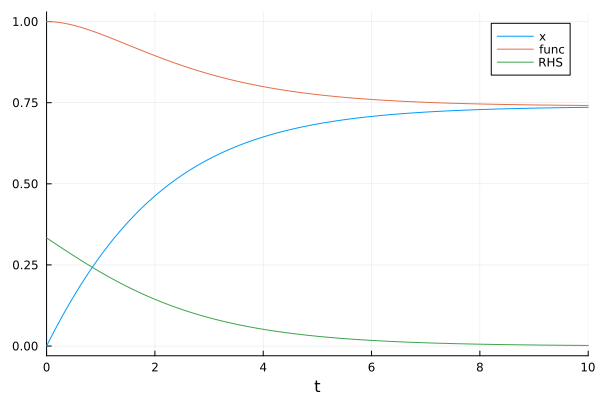

In [24]:
prob = ODEProblem(fol, [], (0.0, 10.0), [])
sol = solve(prob)
plot(sol, idxs = [fol.x, fol.func, fol.RHS])

In [25]:
value_vector = randn(10)
f_fun(t) = t >= 10 ? value_vector[end] : value_vector[Int(floor(t)) + 1]
@register_symbolic f_fun(t)

@mtkmodel FOLExternalFunction begin
    @parameters begin
        τ = 0.75 # parameters and their values
    end
    @variables begin
        x(t) = 0.0 # dependent variables and their initial conditions
        f(t)
    end
    @equations begin
        f ~ f_fun(t)
        D(x) ~ (f - x) / τ
    end
end

@mtkbuild fol_external_f = FOLExternalFunction()

Model fol_external_f with 1 equations
Unknowns (1):
  x(t) [defaults to 0.0]
Parameters (1):
  τ [defaults to 0.75]

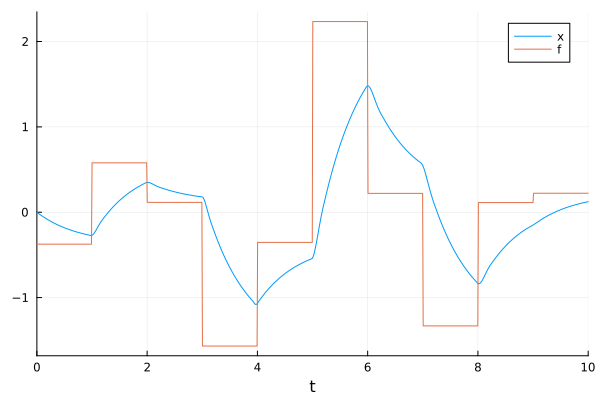

In [26]:
prob = ODEProblem(fol_external_f, [], (0.0, 10.0), [])
sol = solve(prob)
plot(sol, idxs = [fol_external_f.x, fol_external_f.f])

Building component based hierarchical models

In [27]:
@mtkmodel FOLUnconnectedFunction begin
    @parameters begin
        τ # parameters
    end
    @variables begin
        x(t) # dependent variables
        f(t)
        RHS(t)
    end
    @equations begin
        RHS ~ f
        D(x) ~ (RHS - x) / τ
    end
end
@mtkmodel FOLConnected begin
    @components begin
        fol_1 = FOLUnconnectedFunction(; τ = 2.0, x = -0.5)
        fol_2 = FOLUnconnectedFunction(; τ = 4.0, x = 1.0)
    end
    @equations begin
        fol_1.f ~ 1.5
        fol_2.f ~ fol_1.x + fol_1.RHS
    end
end
#@mtkbuild fol_1 = FOLUnconnectedFunction(; τ = 2.0, x = -0.5)
@mtkbuild connected = FOLConnected()

Model connected with 2 equations
Unknowns (2):
  fol_1₊x(t) [defaults to -0.5]
  fol_2₊x(t) [defaults to 1.0]
Parameters (2):
  fol_1₊τ [defaults to 2.0]
  fol_2₊τ [defaults to 4.0]

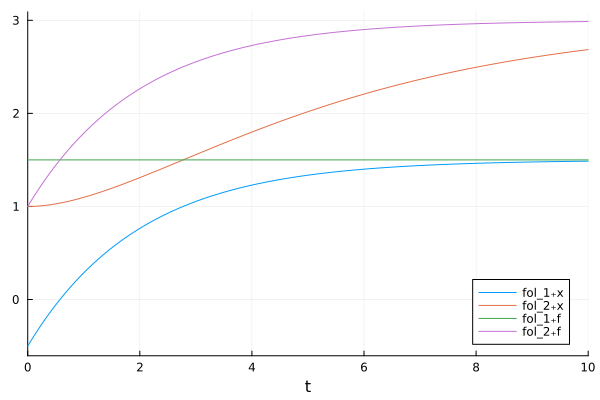

In [28]:
prob = ODEProblem(connected, [], (0.0, 10.0), [])
sol = solve(prob)
plot(sol, idxs = [connected.fol_1.x, connected.fol_2.x, connected.fol_1.f, connected.fol_2.f])

Try the logistic equation
$
\begin{equation}
    \dot{x} = rx \left(1 - \frac{x}{k}\right)
\end{equation}
$

r


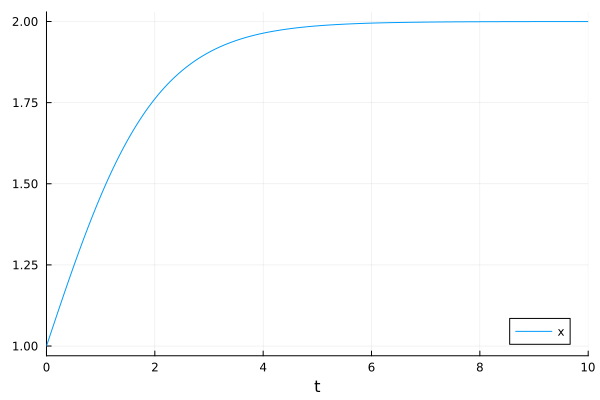

In [29]:
@mtkmodel FOL begin
    @parameters begin
        K = 3.0 # parameters and their values
        r = 1.5
    end
    @variables begin
        x(t) = 1.0 # dependent variables and their initial conditions
    end
    @equations begin
        D(x) ~ r*x * (1 - x / K)
    end
end

@mtkbuild fol = FOL(; r = 1.9, K = 3, x = 3.5)

println(fol.r)

prob = ODEProblem(fol, [1], (0.0, 10.0), [1, 2]) # mtk object, equations (variable initial conditions?), unknowns (t), and initial conditions (parameters?)
sol = solve(prob)
plot(sol, idxs=[fol.x])

# Programmatically Generating and Scripting ODESystems
In the following tutorial, we will discuss how to programmatically generate ODESystems. This is useful for functions that generate ODESystems, for example when you implement a reader that parses some file format, such as SBML, to generate an ODESystem. It is also useful for functions that transform an ODESystem, for example when you write a function that log-transforms a variable in an ODESystem.

## The Representation of a ModelingToolkit System
ModelingToolkit is built on Symbolics.jl, a symbolic Computer Algebra System (CAS) developed in Julia. As such, all CAS functionality is also available to be used on ModelingToolkit systems, such as symbolic differentiation, Groebner basis calculations, and whatever else you can think of. Under the hood, all ModelingToolkit variables and expressions are Symbolics.jl variables and expressions. Thus when scripting a ModelingToolkit system, one simply needs to generate Symbolics.jl variables and equations as demonstrated in the Symbolics.jl documentation. This looks like:

In [2]:
using ModelingToolkit # reexports Symbolics
@variables t x(t) y(t) # Define variables
D = Differential(t)
eqs = [D(x) ~ y
       D(y) ~ x] # Define an array of equations

LoadError: cannot assign a value to imported variable Main.t

However, ModelingToolkit has many higher-level features which will make scripting ModelingToolkit systems more convenient. For example, as shown in the next section, defining your own independent variables and differentials is rarely needed.

## The Non-DSL Way of Defining an ODE System
Using @mtkmodel, like in the getting started tutorial, is the preferred way of defining ODEs with MTK. However generating the contents of a @mtkmodel programmatically can be tedious. Let us look at how we can define the same system without @mtkmodel.

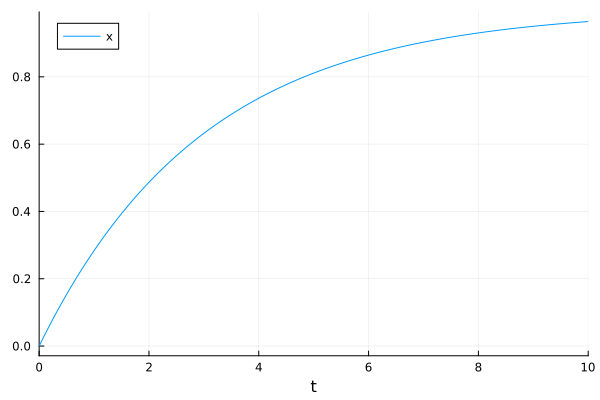

In [33]:
using ModelingToolkit
using ModelingToolkit: t_nounits as t, D_nounits as D
@variables x(t) = 0.0  # independent and dependent variables
@parameters τ = 3.0       # parameters
@constants h = 1    # constants
eqs = [D(x) ~ (h - x) / τ] # create an array of equations

# your first ODE, consisting of a single equation, indicated by ~
@named model = ODESystem(eqs, t)

# Perform the standard transformations and mark the model complete
# Note: Complete models cannot be subsystems of other models!
fol = structural_simplify(model)
prob = ODEProblem(fol, [], (0.0, 10.0), [])
using OrdinaryDiffEq
sol = solve(prob)

using Plots
plot(sol)

As you can see, generating an ODESystem is as simple as creating an array of equations and passing it to the ODESystem constructor.

@named automatically gives a name to the ODESystem, and is shorthand for

In [ ]:
fol_model = ODESystem(eqs, t; name = :fol_model) # @named fol_model = ODESystem(eqs, t)

Model fol_model with 1 equations
Unknowns (1):
  x(t) [defaults to 0.0]
Parameters (1):
  τ [defaults to 3.0]

Thus, if we had read a name from a file and wish to populate an ODESystem with said name, we could do:

In [ ]:
namesym = :name_from_file
fol_model = ODESystem(eqs, t; name = namesym)

Model name_from_file with 1 equations
Unknowns (1):
  x(t) [defaults to 0.0]
Parameters (1):
  τ [defaults to 3.0]

# How do I use non-numeric/array-valued parameters?
In ModelingToolkit.jl version 9, parameters are required to have a symtype matching the type of their values. For example, this will error during problem construction:

In [34]:
@parameters p = [1, 2, 3]

1-element Vector{Num}:
 p

Since by default parameters have a symtype of Real (which is interpreted as Float64) but the default value given to it is a Vector{Int}. For array-valued parameters, use the following syntax:

In [35]:
@parameters p[1:n, 1:m]::T # `T` is the `eltype` of the parameter array
@parameters p::T # `T` is the type of the array

LoadError: UndefVarError: `T` not defined

The former approach is preferred, since the size of the array is known. If the array is not a Base.Array or the size is not known during model construction, the second syntax is required.

The same principle applies to any parameter type that is not Float64.

In [36]:
@parameters p1::Int # integer-valued
@parameters p2::Bool # boolean-valued
@parameters p3::MyCustomStructType # non-numeric
@parameters p4::ComponentArray{...} # non-standard array

LoadError: UndefVarError: `MyCustomStructType` not defined

Getting the index for a symbol
Ordering of symbols is not guaranteed after symbolic transformations, and parameters are now stored in a custom MTKParameters object instead of a vector. Thus, values should be referred to by their name. For example sol[lorenz.x]. To obtain the index, use the following functions from SymbolicIndexingInterface.jl:

In [37]:
variable_index(sys, sym)
parameter_index(sys, sym)

LoadError: UndefVarError: `variable_index` not defined

Note that while the variable index will be an integer, the parameter index is a struct of type ParameterIndex whose internals should not be relied upon.

In [38]:
using ModelingToolkit, OrdinaryDiffEq

@parameters t

@variables z[1:3](t)

@derivatives D'~t

eqs = [D(z[i]) + z[i] ~ 0 for i in 1:3]


LoadError: cannot assign a value to imported variable Main.t